**1.앙상블 학습, Random Forest, GBM (45점)**

1-Q1. 앙상블 학습의 전통적인 유형 세 가지는 무엇인가요?(2점)

1. 보팅 (Voting)
2. 배깅 (Bagging)
3. 부스팅 (Boosting)

1-Q2. 다음 서술이 참인지 거짓인지 판단하세요.(3점)

: 배깅(Bagging) 방식은 서로 다른 알고리즘을 가진 분류기를 결합하여 최종 결정을 도출하는 방식이다.

거짓 (배깅은 같은 분류기들을 사용한다.)

다음은 실습에 필요한 라이브러리 및 데이터 전처리 과정입니다. 그대로 Run 해주세요.
######(이번 복습과제는 아래의 데이터 셋만 사용합니다. 앙상블, 랜덤포레스트, GBM까지 새롭게 데이터를 로드하실 필요는 없습니다)

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import time
import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기
df = pd.read_csv('../data/diabetes.csv')

X = df.drop(['Outcome'], axis=1)
y = df['Outcome']

1-Q3. 일반적으로 보팅 방식 중 소프트 보팅이 하드 보팅보다 성능이 좋아 많이 사용됩니다.

다음 실습을 통해 하드 보팅과 소프트 보팅의 정확도를 비교해보고, 앙상블 방식이 아닌 개별 분류기의 예측 성능 또한 출력해서 비교해보겠습니다.(8점)

사용할 개별 분류기:
1. 로지스틱 회귀
2. K 최근접 이웃
3. 랜덤 포레스트

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 성능 평가 함수
def get_clf_eval(y_test, pred=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [3]:
# 개별 모델 생성
# 로지스틱 회귀의 solver='liblinear' 설정
# K 최근접 이웃의 n_neighbors=8 설정
# 랜덤포레스트의 random_state=11 고정
lr = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)
rf_clf = RandomForestClassifier(random_state=11)

# 데이터 세트 분리
# test_size=0.2, random_state=11로 설정해줍니다.
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=11)

# 하드 보팅 기반의 앙상블 모델로 구현한 분류기 생성
vt_clf = VotingClassifier(estimators=[('LR',lr),('KNN',knn_clf),('rf',rf_clf)],voting='hard')

# Hard Voting Classifier 학습/예측/평가
# 평가는 get_clf_eval로 출력해주세요
vt_clf.fit(X_train,y_train)
vt_pred = vt_clf.predict(X_test)
print('하드보팅 평가결과:\n')
get_clf_eval(y_test,vt_pred)

# 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 생성
softvt_clf = VotingClassifier(estimators=[('LR',lr),('KNN',knn_clf),('rf',rf_clf)],voting='soft')

# Soft Voting Classifier 학습/예측/평가
# 평가는 get_clf_eval로 출력해주세요
softvt_clf.fit(X_train,y_train)
softvt_pred = softvt_clf.predict(X_test)
print('\n=================\n소프트보팅 평가결과:')
get_clf_eval(y_test,softvt_pred)

하드보팅 평가결과:

오차 행렬
[[90 10]
 [29 25]]
정확도: 0.7468, 정밀도: 0.7143, 재현율: 0.4630

소프트보팅 평가결과:
오차 행렬
[[86 14]
 [26 28]]
정확도: 0.7403, 정밀도: 0.6667, 재현율: 0.5185


In [4]:
# 개별 모델의 학습/예측/평가
# 세 가지 분류기를 리스트 형태로 저장
clf_list = [lr, knn_clf,rf_clf]
clf_names = ['Logistic Regression','KNN','RandomForest']

# for문을 사용하여 분류기 이름과 해당 분류기를 사용했을 때의 get_clf_eval 출력
for idx in range(len(clf_list)):
    clf_list[idx].fit(X_train,y_train)
    clf_pred = clf_list[idx].predict(X_test)
    print(f'\n====={clf_names[idx]}의 평가 결과=====')
    get_clf_eval(y_test,clf_pred)


=====Logistic Regression의 평가 결과=====
오차 행렬
[[90 10]
 [31 23]]
정확도: 0.7338, 정밀도: 0.6970, 재현율: 0.4259

=====KNN의 평가 결과=====
오차 행렬
[[88 12]
 [31 23]]
정확도: 0.7208, 정밀도: 0.6571, 재현율: 0.4259

=====RandomForest의 평가 결과=====
오차 행렬
[[85 15]
 [28 26]]
정확도: 0.7208, 정밀도: 0.6341, 재현율: 0.4815


1-Q4. 하드 보팅 방식의 경우 예측 결과값을 다수결로 투표하여 최종값을 결정하므로 predict_proba를 구하거나 임계값을 조절할 수 없습니다.


소프트 보팅 방식을 사용하여 임계값을 달리하며 정확도, 정밀도, 재현율을 출력해보세요.(임계값은 0부터 1까지 0.1씩 증가하도록 해주세요.)

(6점)

In [5]:
from sklearn.preprocessing import Binarizer

# 0부터 1까지 0.1 step으로 하는 리스트를 생성하여 custom_thresholds에 저장
custom_thresholds = [i*0.1 for i in range(11)]

# 소프트 보팅의 positive에 대한 예측 확률을 pred_proba_c1에 저장한 후 2차원 배열로 변환
pred_proba_c1 = softvt_clf.predict_proba(X_test)[:,1]
pred_proba_c1 = pred_proba_c1.reshape((-1,1))

# for문을 이용하여 임계값에 따른 get_clf_eval결과 출력
for t in custom_thresholds:
    print(f'\n===Threshold = {t}일 때===')
    temp_pred = list(map(lambda x:1 if x>t else 0,pred_proba_c1.copy()))
    get_clf_eval(y_test,temp_pred)


===Threshold = 0.0일 때===
오차 행렬
[[  0 100]
 [  0  54]]
정확도: 0.3506, 정밀도: 0.3506, 재현율: 1.0000

===Threshold = 0.1일 때===
오차 행렬
[[23 77]
 [ 2 52]]
정확도: 0.4870, 정밀도: 0.4031, 재현율: 0.9630

===Threshold = 0.2일 때===
오차 행렬
[[54 46]
 [ 4 50]]
정확도: 0.6753, 정밀도: 0.5208, 재현율: 0.9259

===Threshold = 0.30000000000000004일 때===
오차 행렬
[[72 28]
 [13 41]]
정확도: 0.7338, 정밀도: 0.5942, 재현율: 0.7593

===Threshold = 0.4일 때===
오차 행렬
[[82 18]
 [23 31]]
정확도: 0.7338, 정밀도: 0.6327, 재현율: 0.5741

===Threshold = 0.5일 때===
오차 행렬
[[86 14]
 [26 28]]
정확도: 0.7403, 정밀도: 0.6667, 재현율: 0.5185

===Threshold = 0.6000000000000001일 때===
오차 행렬
[[93  7]
 [33 21]]
정확도: 0.7403, 정밀도: 0.7500, 재현율: 0.3889

===Threshold = 0.7000000000000001일 때===
오차 행렬
[[100   0]
 [ 42  12]]
정확도: 0.7273, 정밀도: 1.0000, 재현율: 0.2222

===Threshold = 0.8일 때===
오차 행렬
[[100   0]
 [ 50   4]]
정확도: 0.6753, 정밀도: 1.0000, 재현율: 0.0741

===Threshold = 0.9일 때===
오차 행렬
[[100   0]
 [ 54   0]]
정확도: 0.6494, 정밀도: 0.0000, 재현율: 0.0000

===Threshold = 1.0일 때===
오차 행렬
[[100   0]
 [ 54

1-Q5. 앞서 앙상블 문제에서 활용한 X,y를 train_test_split을 이용하여 train,test 데이터로 분류해주세요.(단, test_size = 0.2 , random_state =0으로 지정)(2점)

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

아래의 코드를 실행시켜 주세요.

In [7]:
rf_clf = RandomForestClassifier(random_state=0)

rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)

accuracy = accuracy_score(y_test,pred)

print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도 : 0.7857


1-Q6. 위의 코드에서 랜덤 포레스트 객체 생성시 파라미터를 추가해 정확도를 개선해주세요. <br/>(단, random_state =0는 고정)(8점)

In [8]:
# RandomForestClassifier 객체를 생성
rf_clf = RandomForestClassifier(random_state=0,n_estimators=500,n_jobs=-1,max_depth=5,min_samples_split=10)

# rf_clf를 이용하여 랜덤 포레스트 학습 및 예측 성능을 평가
rf_clf.fit(X_train,y_train)
rf_pred = rf_clf.predict(X_test)

# 정확도를 accuracy변수에 저장
accuracy = accuracy_score(y_test,rf_pred)

print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도 : 0.8312


앙상블 문제에서 사용한 X,y를 train_test_split() 함수로 학습 데이터와 테스트 데이터로 분류하세요.

In [9]:
# X_features와 y_label을 test_size = 0.2로 분리하고 random_state는 156으로 지정
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=156)

1-Q7. 데이터셋을 Adaboost으로 학습하여 정확도와 수행 시간을 측정하세요.(8점)

- 수행 시간 계산을 위해서는 time 모듈을 활용하고 모든 수치는 소수점 4번째 자리에서 반올림하세요.
- n_estimators=50, learning_rate=1로 지정합니다.

In [10]:
# 시작 시간 설정
start_time = time.time()

# Adaboost 학습 및 예측
ada_clf = AdaBoostClassifier(n_estimators=50,learning_rate=1)
ada_clf.fit(X_train,y_train)
ada_pred = ada_clf.predict(X_test)

# Adaboost 정확도와 수행시간 출력
ada_accuracy = accuracy_score(y_test,ada_pred)
print("정확도 : {:.3f}, 수행시간 : {:.3f}".format(ada_accuracy,time.time()-start_time))

정확도 : 0.753, 수행시간 : 0.076


1-Q8. 데이터를 GBM으로 학습하여 정확도와 GBM 수행 시간을 측정하세요.(8점)
- 모든 수치는 소수점 4번째 자리에서 반올림하여 출력하세요.

In [11]:
from sklearn.model_selection import GridSearchCV

# 시작 시간 설정
start_time = time.time()

# GBM 학습 및 예측
gbm = GradientBoostingClassifier()
gbm.fit(X_train,y_train)
gbm_pred = gbm.predict(X_test)
print("정확도 : {:.3f}, 수행시간 : {:.3f}".format(accuracy_score(y_test,gbm_pred),
                                           time.time()-start_time))

# n_estimators 와 learning_rate는 각각 자유롭게 2개씩 설정하여 params 변수에 딕셔너리 형태로 지정하세요.
params = {'n_estimators':[200,400],
         'learning_rate':[0.1,0.05]}

# GridSearchCV를 적용하여 하이퍼 파라미터를 최적화해봅니다.
gscv = GridSearchCV(estimator=gbm,param_grid=params,cv=3)
gscv.fit(X_train,y_train)

# GMB 최적 하이퍼 파라미터, 최고 예측 정확도와 수행시간을 순서대로 출력하세요.
print('최적 하이퍼 파라미터:',gscv.best_params_)
print('최고 예측 정확도: {:.3f}'.format(gscv.best_score_))
print('수행시간: {:.3f}'.format(time.time()-start_time))

# 최적으로 학습된 estimator로 예측 수행하고 정확도를 출력하세요.
best_gbm = gscv.best_estimator_
best_pred = best_gbm.predict(X_test)
print('예측 정확도: {:.3f}'.format(accuracy_score(y_test,best_pred)))

정확도 : 0.727, 수행시간 : 0.144
최적 하이퍼 파라미터: {'learning_rate': 0.05, 'n_estimators': 200}
최고 예측 정확도: 0.749
수행시간: 6.869
예측 정확도: 0.753


**2.XGBoost, RightGBM (55점)**

아래 데이터를 로드해주세요

In [12]:
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
import numpy as np
from sklearn. model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

diabetes = pd.read_csv('../data/diabetes.csv')

features = diabetes.iloc[:,:-1]
label = diabetes.iloc[:,-1]

2-Q1. 파이썬 래퍼 XGBoost로 학습하여 나온 예측 확률 값과 예측값을 10개씩 출력하세요.(10점)

In [13]:
X_train,X_test,y_train,y_test = train_test_split(features,label,test_size=0.2,random_state=0)

In [14]:
xgb_params = {
    'max_depth':3,
    'eta':0.1,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'ealry_stopping':100
}

In [15]:
import xgboost as xgb
dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)
wlist = [(dtrain,'train'),(dtest,'eval')]

xgb_model = xgb.train(params=xgb_params,dtrain=dtrain,early_stopping_rounds=100,evals=wlist)
xgb_probs = xgb_model.predict(dtest)

print('예측 확률 10개:',np.round(xgb_probs[:10],3))
print('예측 값 10개: ',list(map(lambda x:1 if x>0.5 else 0,(xgb_probs[:10]))))

[19:59:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "ealry_stopping" } are not used.

[0]	train-logloss:0.65802	eval-logloss:0.65642
[1]	train-logloss:0.62687	eval-logloss:0.62707
[2]	train-logloss:0.60171	eval-logloss:0.60167
[3]	train-logloss:0.58065	eval-logloss:0.58101
[4]	train-logloss:0.56173	eval-logloss:0.56335
[5]	train-logloss:0.54583	eval-logloss:0.54959
[6]	train-logloss:0.53090	eval-logloss:0.53690
[7]	train-logloss:0.51828	eval-logloss:0.52487
[8]	train-logloss:0.50617	eval-logloss:0.51396
[9]	train-logloss:0.49591	eval-logloss:0.50611
예측 확률 10개: [0.74  0.306 0.265 0.529 0.251 0.211 0.608 0.73  0.322 0.414]
예측 값 10개:  [1, 0, 0, 1, 0, 0, 1, 1, 0, 0]


2-Q2. 사이킷런 래퍼 XGBoost로 학습하여 나온 예측값을 10개 출력하세요.(파라미터는 Q1과 동일하게 설정해주세요.)(10점)

In [16]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(max_depth=3,learning_rate=0.1,objective='binary:logistic')
evals = [(X_train,y_train),(X_test,y_test)]
xgb_clf.fit(X_train,y_train,eval_set=evals,eval_metric='logloss',
            early_stopping_rounds=100)
xgb_clf_pred = xgb_clf.predict(X_test)
print('예측값 10개:',xgb_clf_pred[:10])

[0]	validation_0-logloss:0.65802	validation_1-logloss:0.65642
[1]	validation_0-logloss:0.62687	validation_1-logloss:0.62707
[2]	validation_0-logloss:0.60171	validation_1-logloss:0.60167
[3]	validation_0-logloss:0.58065	validation_1-logloss:0.58101
[4]	validation_0-logloss:0.56173	validation_1-logloss:0.56335
[5]	validation_0-logloss:0.54583	validation_1-logloss:0.54959
[6]	validation_0-logloss:0.53090	validation_1-logloss:0.53690
[7]	validation_0-logloss:0.51828	validation_1-logloss:0.52487
[8]	validation_0-logloss:0.50617	validation_1-logloss:0.51396
[9]	validation_0-logloss:0.49591	validation_1-logloss:0.50611
[10]	validation_0-logloss:0.48611	validation_1-logloss:0.49946
[11]	validation_0-logloss:0.47789	validation_1-logloss:0.49096
[12]	validation_0-logloss:0.47050	validation_1-logloss:0.48429
[13]	validation_0-logloss:0.46379	validation_1-logloss:0.47902
[14]	validation_0-logloss:0.45760	validation_1-logloss:0.47458
[15]	validation_0-logloss:0.45106	validation_1-logloss:0.47165
[1

지금 LightGBM의 버전이 책과 달라 오류가 발생합니다. 이를 방지하기위해 LightGBM의 버전을 3.3.2로 다운그레이드 하고 런타임을 재시작해주세요
######(이미 버전이 3.2.2라면 그대로 진행해주세요)

In [17]:
import lightgbm
lightgbm.__version__

'3.3.2'

In [18]:
# pip install lightgbm==3.3.2

아래 코드를 실행해주세요

In [19]:
from lightgbm import LGBMClassifier
from lightgbm import plot_metric, plot_tree


X_train, X_test, y_train, y_test=train_test_split(features, label, test_size=0.3, random_state=156 )

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

lgbm_wrapper_of = LGBMClassifier(
                         n_estimators=300,
                         learning_rate=0.05,
                         random_state = 121)

evals = [(X_tr, y_tr),(X_val,y_val)]
lgbm_wrapper_of.fit(X_tr, y_tr, eval_metric="logloss", eval_set=evals, verbose=False )
preds_of = lgbm_wrapper_of.predict(X_test)
pred_proba_of = lgbm_wrapper_of.predict_proba(X_test)[:, 1]

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)

    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

In [21]:
get_clf_eval(y_test,preds_of,pred_proba_of)

오차행렬
[[116  31]
 [ 31  53]]
정확도: 0.7316, 정밀도: 0.6310, 재현율: 0.6310, F1: 0.6310, AUC:0.7100


위의 LightGBM은 수행 중 여러 파라미터를 빼먹어 과적합이 발생했습니다

###### 2-Q3.과적합이 발생했음을 시각적으로 보여주세요(5점)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

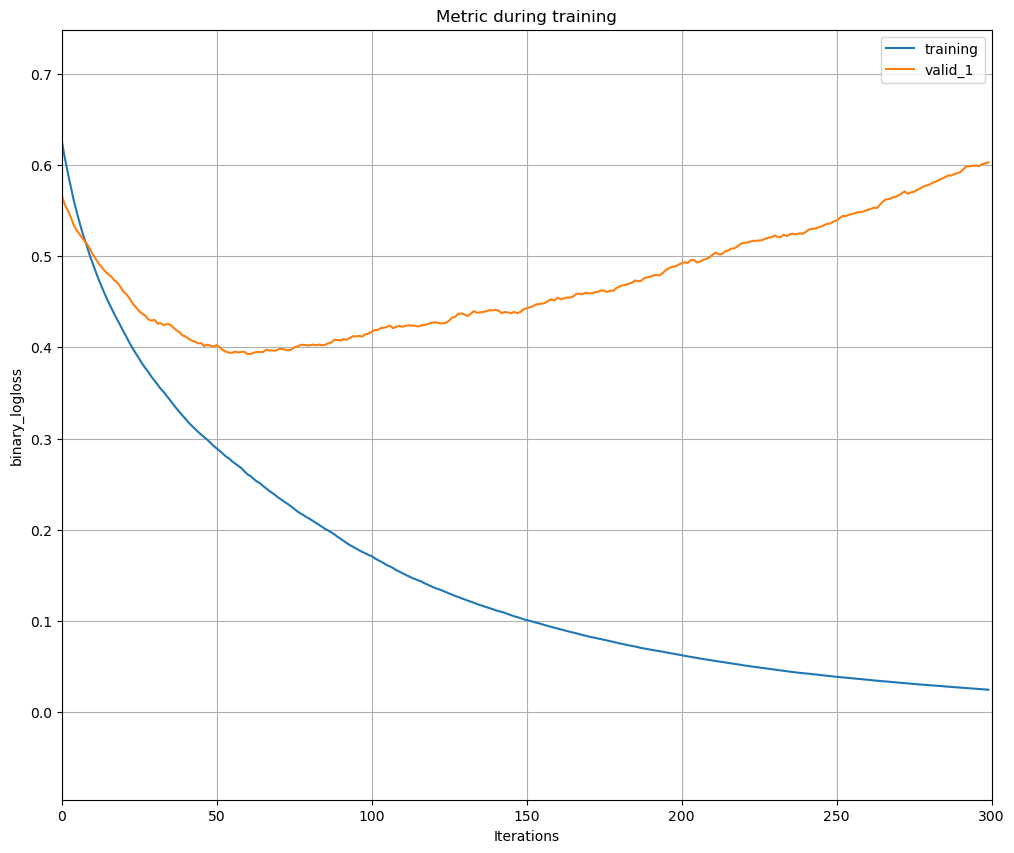

In [22]:
plot_metric(lgbm_wrapper_of,figsize=(12,10))
# 해석: Iterations(epoch = 학습단위로, 1번의 학습을 의미)이 증가함에따라, 
#       학습 데이터의 loss(손실,비용)는 감소하고 있지만,
#       검증 데이터의 loss는 증가하고 있다. 
#       이는 모델이 학습 데이터는 잘 분류하고 있지만, 
#       새로운 유형의 데이터인 검증데이터는 잘 분류하지 못하고 있음을 의미한다.
#       >> 과적합

######2-Q4. 위의 코드를 수정하여 정확도 2%P 이상 상승해 주세요
###### (단 n_estimatorssms 400, random_stat는 156으로 고정해주세요)(10점)

In [27]:
from hyperopt import hp

In [34]:
lgbm_search_space = {
    'max_depth':hp.quniform('max_depth',10,80,5),
    'min_child_samples':hp.quniform('min_child_samples',2,40,1),
    'num_leaves':hp.quniform('num_leaves',40,160,5),
    'learning_rate':hp.uniform('learning_rate',0.01,0.2),
    'colsample_bytree':hp.uniform('colsample_bytree',0.5,1),
    'subsample':hp.uniform('subsample',0.5,1),
    'reg_lambda':hp.uniform('reg_lambda',0.1,0.5),
    'reg_alpha':hp.uniform('reg_alpha',0.0,0.5)
}

In [47]:
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK
def objective_func(search_space):
    lgbm_clf = LGBMClassifier(n_estimators=400,random_state=156,
                              max_depth=int(search_space['max_depth']),
                              min_child_samples=int(search_space['min_child_samples']),
                              num_leaves=int(search_space['num_leaves']),
                              learning_rate=search_space['learning_rate'],
                              colsample_bytree=search_space['colsample_bytree'],
                              subsample=search_space['subsample'],
                              reg_lambda=search_space['reg_lambda'],
                              reg_alpha=search_space['reg_alpha']
                             )
    lgbm_clf.fit(X_tr, y_tr, eval_metric="logloss", eval_set=evals, verbose=False)
    accuracy = accuracy_score(y_test,lgbm_clf.predict(X_test))
    return {'loss':-(accuracy),'status':STATUS_OK}

In [48]:
from hyperopt import fmin, tpe, Trials
trial_val = Trials()
best = fmin(fn=objective_func,
           space = lgbm_search_space,
           algo=tpe.suggest,
           max_evals=50,
           trials=trial_val)
print('best:',best)

100%|███████████████████████████████████████████████| 50/50 [00:10<00:00,  4.81trial/s, best loss: -0.7705627705627706]
best: {'colsample_bytree': 0.983258023454106, 'learning_rate': 0.016034285021889888, 'max_depth': 10.0, 'min_child_samples': 15.0, 'num_leaves': 140.0, 'reg_alpha': 0.26391015644724564, 'reg_lambda': 0.3981491551167523, 'subsample': 0.815023321260921}


In [49]:
lgbm_improved = LGBMClassifier(
    n_estimators=400,
    random_state = 156, 
    colsample_bytree = best['colsample_bytree'],
    learning_rate = best['learning_rate'],
    max_depth=int(best['max_depth']),
    min_child_samples = int(best['min_child_samples']),
    num_leaves=int(best['num_leaves']),
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    subsample=best['subsample']
)

evals = [(X_tr, y_tr),(X_val,y_val)]
lgbm_improved.fit(X_tr, y_tr, eval_metric="logloss", eval_set=evals, verbose=False )
preds_imp = lgbm_improved.predict(X_test)

In [51]:
lgbm_of_accuracy = accuracy_score(y_test,preds_of)
lgbm_accuracy = accuracy_score(y_test,preds_imp)
print('{:.2f}%P 개선된 정확도: {:.4f}'.format(lgbm_accuracy*100-lgbm_of_accuracy*100,lgbm_accuracy))

3.90%P 개선된 정확도: 0.7706



###### 2-Q5. GridSearchCV를 활용해 learnig_rate, max_depth, num_leaves, n_estimators의 최적 파라미터를 구하고 GridSeaechCV의 수행시간, 최고 정확도를 구하고 GridSearchCV가 XGBoosth, LightGBM에 적합하지 않는 이유를 말해주세요
###### cv = 3, refit=True로 고정해주세요(10점)

In [53]:
from sklearn.model_selection import GridSearchCV
import time
start_time = time.time()

param_lgbm = {"learning_rate" : [0.1,0.5,0.3],
             "max_depth" : [20,25,30],
             "num_leaves" : [100,145],
             'n_estimators': [400,300]
              }
lgbm_tt = LGBMClassifier(random_state=156)
lgbm_gscv = GridSearchCV(lgbm_tt,param_grid=param_lgbm,cv=3,refit=True)

lgbm_gscv.fit(X_tr,y_tr,eval_metric='logloss',eval_set=evals,verbose=False)
print('최고 정확도: {:.4f}'.format(lgbm_gscv.best_score_))
print('수행시간: {:.4f}'.format(time.time()-start_time))

최고 정확도: 0.7246
수행시간: 13.6705


<span style='color:red'>답:</span>   
1. 조정해야 할 하이퍼 파라미터가 너무 많아서 수행시간이 오래 걸린다.
2. 기본적으로도 좋은 성능을 가지고 있으므로, 무작위 탐색 또는 베이지안 최적화 방식의 하이퍼 파라미터 튜닝이 더 효율적이다.

###### 2-Q6. 이제 실제로 해당 파라미터를 적용해 학습하고, 검증한뒤 get_clf_eval 함수를 사용해 실제 정확도를 도출해주세요
######도출된 정확도를 바탕으로 해석해주세요 (만약 정확도가 같다면 그대로 두고, 정확도가 다르다면 그 이유를 해석해 주세요)
###### (random_state는 모두 156으로 고정해 주세요)(10점)

In [54]:
# 도출한 최적의 파라미터 조합
print(best)

{'colsample_bytree': 0.983258023454106, 'learning_rate': 0.016034285021889888, 'max_depth': 10.0, 'min_child_samples': 15.0, 'num_leaves': 140.0, 'reg_alpha': 0.26391015644724564, 'reg_lambda': 0.3981491551167523, 'subsample': 0.815023321260921}


In [55]:
# 적용된 객체
lgbm_improved

LGBMClassifier(colsample_bytree=0.983258023454106,
               learning_rate=0.016034285021889888, max_depth=10,
               min_child_samples=15, n_estimators=400, num_leaves=140,
               random_state=156, reg_alpha=0.26391015644724564,
               reg_lambda=0.3981491551167523, subsample=0.815023321260921)

In [57]:
get_clf_eval(y_test,lgbm_improved.predict(X_test))

오차행렬
[[127  20]
 [ 33  51]]
정확도: 0.7706, 정밀도: 0.7183, 재현율: 0.6071, F1: 0.6581, AUC:0.7355


###### 해석:

# 문제 3. 위스콘신 유방암 예측

## 3-0. VotingClassifier 알고리즘의 두 주요 생성 인자는?(4점)

답:

## 유방암 데이터 보팅

In [58]:
# 다음 코드를 실행하세요
import pandas as pd
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


### 3-1-1. 로지스틱 회귀와 KNN을 기반으로 한 소프트 보팅 분류기를 생성하시오. (solver = liblinear, n_neighbors=8, random_state = 42) (8점)

In [61]:
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)
dt_clf = DecisionTreeClassifier(random_state=42)

vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf),('DT',dt_clf)]
                          ,voting='soft')

X = cancer.data
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### 3-1-2. 보팅 분류기 학습/예측/평가 (fit, predict, accuracy_score 사용, 소숫점 4째짜리 까지 반올림 할 것) (7점)

In [63]:
vo_clf.fit(X_train,y_train)
np.round(accuracy_score(y_test,vo_clf.predict(X_test)),4)

0.9737

### 3-1-3. 개별 모델 학습/예측/평가(for 반복문 사용) (6점)

In [64]:
classifiers = [lr_clf,knn_clf,dt_clf]
for classifier in classifiers:
    classifier.fit(X_train,y_train)
    accuracy = accuracy_score(y_test,classifier.predict(X_test))
    
    class_name = classifier.__class__.__name__
    print('분류기:{}, 정확도:{:.4f}'.format(class_name,accuracy))

분류기:LogisticRegression, 정확도:0.9561
분류기:KNeighborsClassifier, 정확도:0.9561
분류기:DecisionTreeClassifier, 정확도:0.9474


## 3-2-0. GBM은 가중치 업데이트를 할 때 ()의 방법을 사용합니다. ()안에 들어갈 방법은?(2점)

In [66]:
'경사하강법 (Gradient Descent)'

'경사하강법 (Gradient Descent)'

## 3-2. 파이썬 래퍼 XGBoost

In [67]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


### 3-2-1. 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터로 추출하고, 만든 train 데이터를 다시 쪼개서 90%는 학습용 데이터, 10%는 검증용 데이터로 분리하세요 (random_state = 156)(8점)

In [68]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 컬럼이 Label임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출.
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train,X_test,y_train,y_test = train_test_split(X_features,y_label,test_size=0.2,random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
# 변수 명은 X_tr, X_val, y_tr, y_val로 할 것
X_tr, X_val, y_tr, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=156)

### 3-2-2. 만든 X_train, X_test, X_tr, X_val의 shape를 확인해주세요(2점)

In [69]:
print(X_train.shape)
print(X_test.shape)
print(X_tr.shape)
print(X_val.shape)

(455, 30)
(114, 30)
(409, 30)
(46, 30)


### 3-2-3. 학습, 검증, 테스트용 DMatrix를 생성하세요(3점)

In [70]:
# 학습, 검증, 테스트용 DMatrix를 생성.
dtr = xgb.DMatrix(data=X_tr,label=y_tr)
dval = xgb.DMatrix(data=X_val,label=y_val)
dtest = xgb.DMatrix(data=X_test,label=y_test)

### 3-2-4. early_stopping_rounds의 값을 50으로 선정해서 모델이 정확하게 조기 중단하였는지 확인해주세요(2점)

In [72]:
params = { 'max_depth':3,
          'eta': 0.05,
          'objective':'binary:logistic',
          'eval_metric':'logloss'
         }
num_rounds = 400

# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval' 로 명기합니다.
eval_list = [(dtr,'train'),(dval,'eval')] # 또는 eval_list = [(dval,'eval')] 만 명기해도 무방.

# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtr , num_boost_round=num_rounds ,
                      early_stopping_rounds= 50 , evals=eval_list)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

[170]	train-logloss:0.01312	eval-logloss:0.26133
[171]	train-logloss:0.01304	eval-logloss:0.26148
[172]	train-logloss:0.01297	eval-logloss:0.26157
[173]	train-logloss:0.01285	eval-logloss:0.26253
[174]	train-logloss:0.01278	eval-logloss:0.26229
[175]	train-logloss:0.01267	eval-logloss:0.26086
[176]	train-logloss:0.01258	eval-logloss:0.26103


### 3-2-5. get_clf_eval() 함수를 이용해서 오차 행렬, 정확도, 정밀도, 재현율, F1 score, AUC score를 확인해주세요(2점)

In [73]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

pred_probs = xgb_model.predict(dtest)
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [74]:
# get_clf_eval() 함수 사용
get_clf_eval(y_test,preds,pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


### 3-2-6. plot_importance() 함수로 Feature importance를 확인해주세요(2점)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

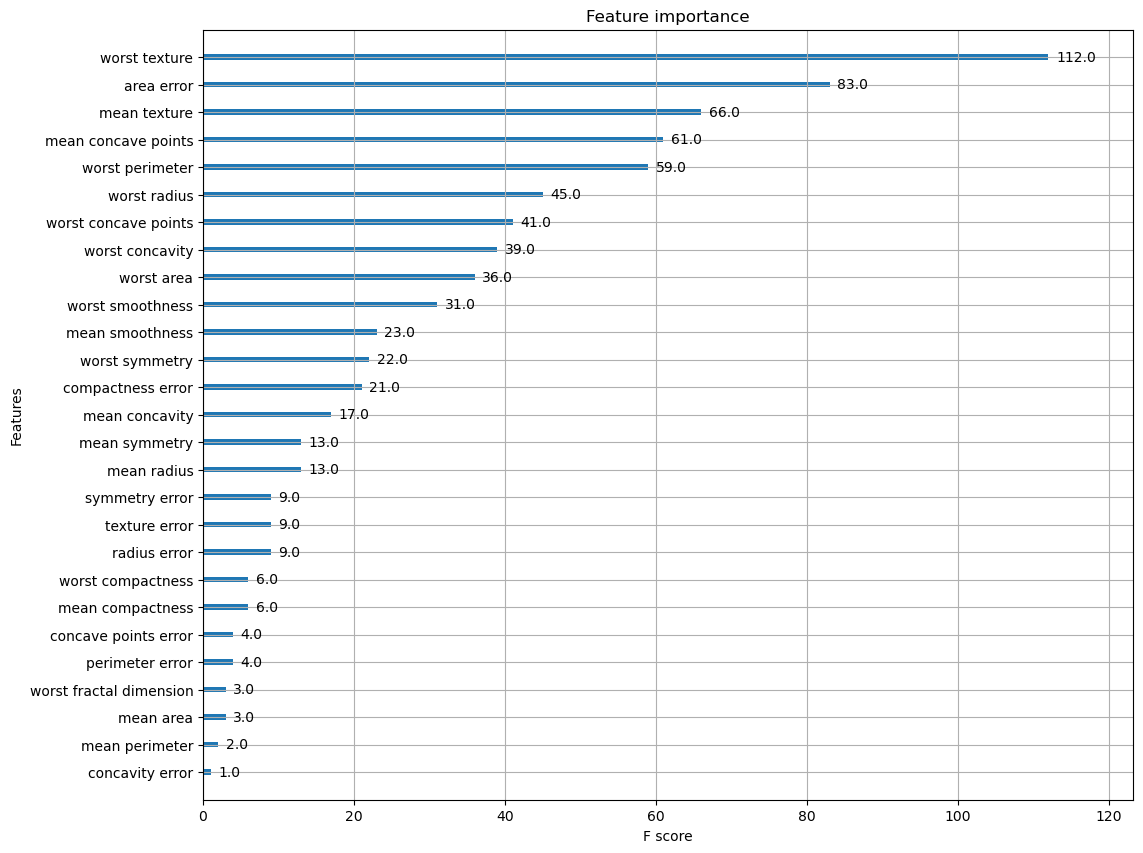

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(figsize=(12,10))
# plot_importance() 함수 사용
plot_importance(xgb_model,ax=ax)

## 3-3. 사이킷런 래퍼 XGBoost 적용 (파라미터명의 변화를 주의해주세요)

### 3-3-1. early_stopping_rounds의 값을 100 -> 10으로 설정하면서 get_clf_eval() 함수를 이용해 정확도 값의 변화를 확인해주세요(4점)

In [76]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds= 100 , eval_metric="logloss", eval_set=evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08620
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08645
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [77]:
# get_clf_eval() 함수로 정확도 확인
get_clf_eval(y_test,ws100_preds,ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


In [78]:
# early_stopping_rounds를 10으로 설정하고 재 학습.
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds= 10 , eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test,ws10_preds,ws10_pred_proba)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

## 3-4. 랜덤 포레스트

#### 3-4-1. GridSearchCV를 이용해 최적의 하이퍼파라미터를 찾고 최고 예측 정확도를 출력하세요. (max_leaf_nodes 값 : 2~20, min_samples_split 값 : 2,3,4) (5점)

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

params = {
    'max_leaf_nodes':[x for x in range(2,21)],
    'min_samples_split':[2,3,4]
}

# RandomForestClassifier 객체 생성 (n_estimators=10, random_state=0 으로 설정)
rf_clf = RandomForestClassifier(n_estimators=10,random_state=0)
# GridSearchCV 수행 (cv=3 으로 설정)
gscv = GridSearchCV(rf_clf, param_grid=params, cv = 3)
# 최고 예측 정확도 출력
gscv.fit(X_train,y_train)
print("최고 예측 정확도 : {:.4f}".format(gscv.best_score_))

최고 예측 정확도 : 0.9627


#### 3-4-2. 최적의 하이퍼파라미터로 랜덤 포레스트를 다시 학습시키고, OOB 샘플의 정확도를 출력하세요. (랜덤 포레스트 객체 생성 시 oob_score=True 로 설정해야 합니다.) (3점)

In [88]:
rf_clf = gscv.best_estimator_ # 최적의 파라미터로 학습된 estimator
rf_clf=rf_clf.set_params(oob_score=True)
rf_clf.fit(X_train,y_train)
oob_accuracy = rf_clf.oob_score_
print('OOB 정확도:',np.round(oob_accuracy,4))

OOB 정확도: 0.9297


#### 3-4-3. feature_importances 속성을 이용해서 가장 영향력 있는 상위 10개 속성의 중요도를 시각화 하세요. (7점)

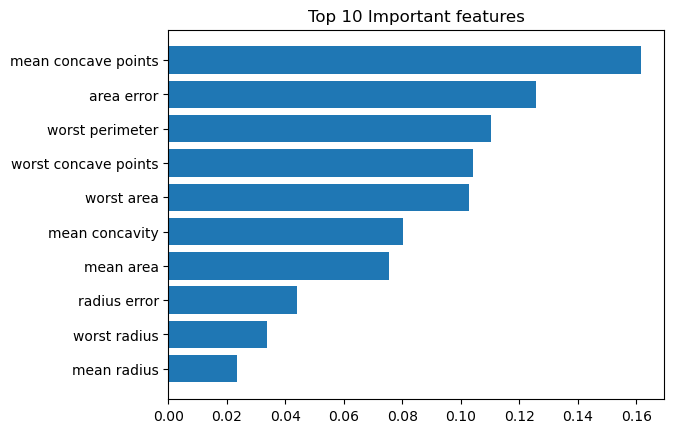

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
fi = dict(zip(rf_clf.feature_names_in_,rf_clf.feature_importances_))
fi_desc = sorted(fi,key=lambda x : fi.get(x),reverse=True)
top10_import_score = []
for key in fi_desc[:10]:
    top10_import_score.append(fi.get(key))
plt.barh(y=list(reversed(fi_desc[:10])),width=list(reversed(top10_import_score)))
plt.title('Top 10 Important features')
plt.show()

## 3-5 LightGBM

#### 3-5-1. n_estimators를 400으로 설정하여 객체를 생성하고,  XGBoost와 같은 시기에 조기 중단을 수행하도록 학습을 진행하세요. (10점)

In [119]:
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

LGBMClassifier(learning_rate=0.05, n_estimators=400)

#### 3-5-2. LightGBM의 XGBoost 대비 장점을 서술하시오. (5점)

1. LGBM은 leaf-wise 방식으로 트리를 분할하기 때문에 일반적으로 학습 속도가 더 빠르다.
2. leaf-wise방식은 level-wise방식에 비해 메모리 사용량이 적으므로 LGBM의 메모리 사용량이 더 적다. >> Stack Overflow 문제가 생길 가능성이 적다.
3. 대규모 데이터셋 학습 시 성능이 LGBM이 더 좋다.

#### 3-5-3. LightGBM의 트리 분할 방식을 서술하고, 해당 분할 방식을 사용하는 이유를 서술하시오. (5점)

lightGBM은 leaf-wise 방식으로 트리를 분할한다. 일반적인 트리 구조의 모델들은 level-wise 방식으로 데이터를 분할하는데 이런 방법은 트리의 max_depth는 줄여주지만, 학습을 수행하는 데 시간이 오래 걸린다는 단점이 있다.      
반면 leaf-wise는 무조건 트리를 이진분할하고, 분할된 두 노드 중 손실값이 더 큰 노드만 계속 이진분할한다는 특징이 있다. <span style='color:green'>이런 방식은 max_depth가 엄청 늘어나지만, 오히려 과적합을 개선하는 데에 효과적이고 수행시간도 빠르다. (단, 하이퍼 파라미터를 조정하지 않을 때에는 두 방식의 성능과 속도가 같다.)</span>    <br>  <span style='color:red'>참고: https://datascience.stackexchange.com/questions/26699/decision-trees-leaf-wise-best-first-and-level-wise-tree-traverse</span>

#### 3-5-4. 모델의 복잡도를 줄이는 기본 튜닝 방안이 무엇인지 서술하시오. (5점)

하이퍼 파라미터 튜닝, 데이터 정규화 등을 통한 데이터 단순화, 일부 피처만 선택 등의 방안들이 있다.

# 문제4. make_moons 데이터셋 분류

In [120]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=300, noise=0.4,random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

## 4-1. 결정 트리와 랜덤 포레스트

#### 4-1-1. 결정트리의 하이퍼 파라미터를 모두 디폴트 값으로 설정해 학습시키고, 정확도를 출력하세요. (random_state=10) (3점)

In [121]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=10)
dt.fit(X_train,y_train)
dt_accuracy = accuracy_score(y_test,dt.predict(X_test))
print(np.round(dt_accuracy,4))

0.8


#### 4-1-2. 다음은 분류기의 결정경계를 시각화하는 함수입니다. 셀을 실행시키고, 결정 트리의 결정경계를 시각화해주세요. (2점)

In [122]:
import numpy as np

# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()

    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()

    # 호출 파라미터로 들어온 training 데이타로 model 학습 .
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행.
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # contourf() 를 이용하여 class boundary 를 visualization 수행.
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)

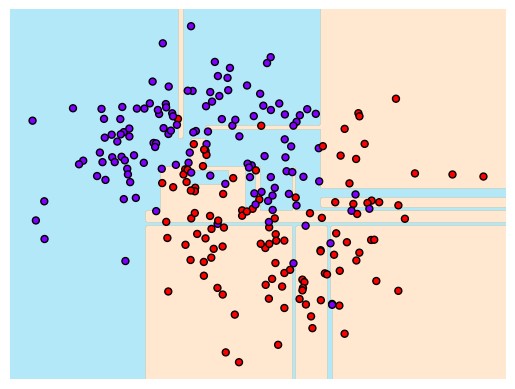

In [123]:
visualize_boundary(dt,X_train,y_train)

#### 4-1-3. 100개의 결정트리를 갖는 랜덤포레스트 모델을 학습시키고, 결정경계를 시각화하세요. (3점)

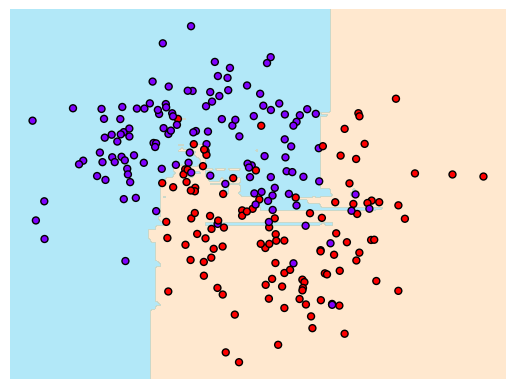

In [124]:
rf = RandomForestClassifier(n_estimators=100,random_state=10)
visualize_boundary(rf,X_train,y_train)

#### 4-1-4. 결정트리와 랜덤포레스트의 결정경계를 비교하고, 이런 차이가 만들어지는 이유를 간단하게 설명하세요. (2점)

- 결정경계 비교 : 결정트리의 경우, 하이퍼 파라미터를 조정하지 않아 모든 리프 노드의 불순도가 0이 될 때까지 데이터를 분할하여 거의 모든 이상치를 만족하도록 결정 경계가 형성되었다. 반면, 랜덤포레스트는 결정트리보다는 이상치에 민감하지 않게 결정 경계가 형성되었다.
<br>
- 이유 : 랜덤포레스트 역시 하이퍼 파라미터를 조절하지 않았기 때문에 랜덤포레스트를 구성하는 100개의 결정트리도 마찬가지로 모든 리프 노드의 불순도가 0이 될 때까지 아주 세세히 분할한다. 그러나, 랜덤포레스트는 원본 데이터셋으로부터 각 결정트리에 데이터를 분할할 때 부트스트래핑 방식을 활용하기 때문에, 무작위로 복원 추출된 데이터셋들에 의해 100개의 결정트리가 서로 다른 결정경계를 가질 가능성이 크다. 만약 랜덤포레스트가 부트스트래핑 방식의 데이터 분할을 하지 않았더라면, 결정트리와 같은 결정경계를 가졌을 것이다.